In [5]:
from datetime import timedelta, datetime
import pandas as pd

hugas = pd.read_csv('QBElec.csv')
 
hugas2 = pd.melt(hugas, id_vars=["Date"], var_name='time')
hugas2['time'] = pd.to_timedelta(hugas2['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
hugas2['Date'] = pd.to_datetime(hugas2['Date'], format="%m/%d/%Y")
hugas2['Datetime'] = hugas2['Date'] + hugas2['time']
hugas2 = hugas2.set_index('Datetime')
hugas2 = hugas2.drop(['Date', 'time'], axis=1).sort_index()

In [6]:
hugas2

,value
Datetime,
2008-03-03 00:00:00,0.0
2008-03-03 00:30:00,0.0
2008-03-03 01:00:00,0.0
2008-03-03 01:30:00,0.0
2008-03-03 02:00:00,0.0
...,...
2022-03-01 21:30:00,0.0
2022-03-01 22:00:00,0.0
2022-03-01 22:30:00,0.0


<AxesSubplot:xlabel='Datetime'>

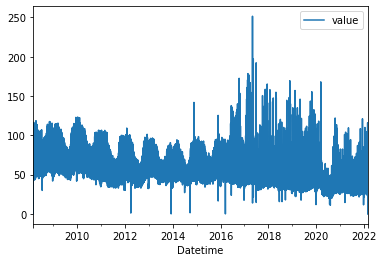

In [7]:
hugas2.plot()

In [8]:
data = hugas2.resample(rule='H').sum()

data.head()

,value
Datetime,
2008-03-03 00:00:00,0.0
2008-03-03 01:00:00,0.0
2008-03-03 02:00:00,0.0
2008-03-03 03:00:00,0.0
2008-03-03 04:00:00,0.0


<AxesSubplot:xlabel='Datetime'>

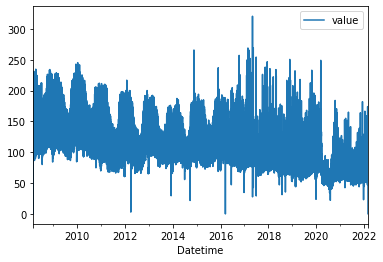

In [9]:
data.plot()

<AxesSubplot:xlabel='Datetime'>

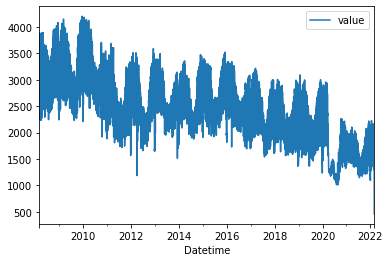

In [10]:
data2 = hugas2.resample(rule='D').sum()
data2.plot()

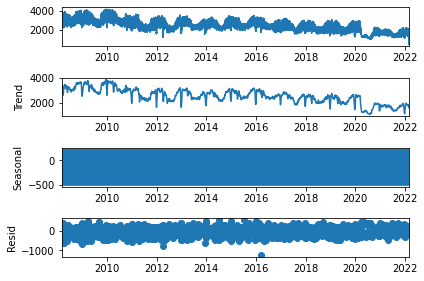

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data2, model='additive')

fig = decomposition.plot()

<AxesSubplot:xlabel='Datetime'>

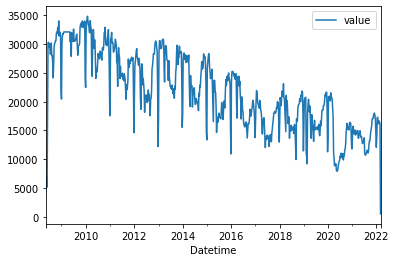

In [126]:
data3 = hugas2.resample(rule='W').sum()
data3.plot()

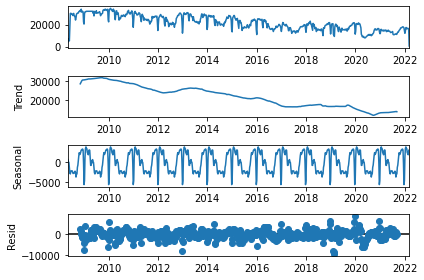

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data3, model='additive')

fig = decomposition.plot()

<AxesSubplot:xlabel='Datetime'>

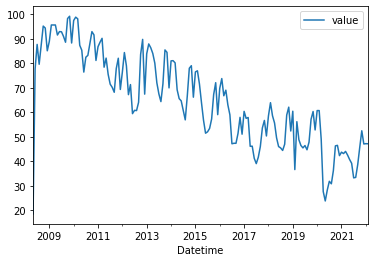

In [128]:
data4 = hugas2.resample(rule='M').mean()
data4.plot()

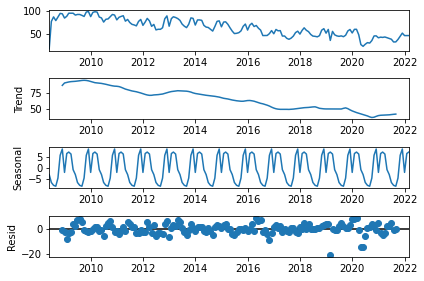

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data4, model='additive')

fig = decomposition.plot()

In [63]:
data2.head()

,value
Datetime,
2008-03-03,2401.768
2008-03-04,3799.027
2008-03-05,3874.801
2008-03-06,3799.476
2008-03-07,3738.969


In [13]:
df = data2

df.head()

,value
Datetime,
2010-01-25,2377.756
2010-01-26,6871.081
2010-01-27,6660.141
2010-01-28,7327.312
2010-01-29,7571.064


In [14]:
train_size = int(len(df) * .95)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(4198, 1) (221, 1)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

In [16]:
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-16-0d4a6bf2fb1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-16-0d4a6bf2fb1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [17]:
train.head()

,value
Datetime,
2010-01-25,-0.470893
2010-01-26,1.262752
2010-01-27,1.181366
2010-01-28,1.438778
2010-01-29,1.532824


In [20]:
import numpy as np

def create_databse(X, y, steps=1):
    Xs, ys = [], []

    for i in range(len(X) - steps):
        v = X.iloc[i:(i + steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + steps])

    return np.array(Xs), np.array(ys)

In [21]:
steps = 30

X_train, y_train = create_databse(train[['value']], train.value, steps)
X_test, y_test = create_databse(test[['value']], test.value, steps)

In [22]:
X_train.shape

(4168, 30, 1)

# LSTM Autoencoder

In [23]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(units=X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')

In [24]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
118/118 [==============================] - 21s 32ms/step - loss: 0.4299 - val_loss: 0.4132
Epoch 2/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2992 - val_loss: 0.4471
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2922 - val_loss: 0.3807
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2748 - val_loss: 0.3618
Epoch 5/10
118/118 [==============================] - 3s 23ms/step - loss: 0.2610 - val_loss: 0.3604
Epoch 6/10
118/118 [==============================] - 3s 23ms/step - loss: 0.2622 - val_loss: 0.3608
Epoch 7/10
118/118 [==============================] - 3s 23ms/step - loss: 0.2563 - val_loss: 0.3433
Epoch 8/10
118/118 [==============================] - 3s 22ms/step - loss: 0.2537 - val_loss: 0.3370
Epoch 9/10
118/118 [==============================] - 3s 24ms/step - loss: 0.2507 - val_loss: 0.3386
Epoch 10/10
118/118 [==============================] - 3s 25ms/step - loss: 0.2453 - val_l

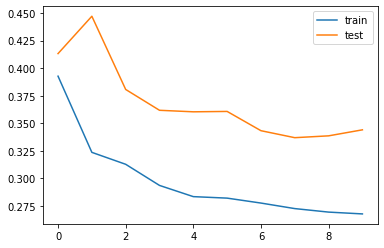

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [26]:
X_train_pred = model.predict(X_train)

In [27]:
train_mae_loss = np.mean(np.abs(X_train_pred, X_train), axis=1)

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

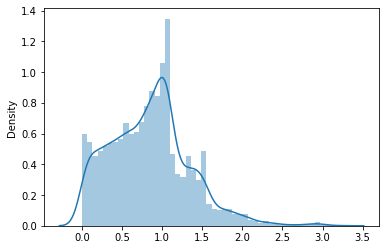

In [28]:
import seaborn as sns

sns.distplot(train_mae_loss, bins=50, kde=True)

In [31]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred, X_test), axis=1)

In [34]:
threshold = 2.5

test_score_df = pd.DataFrame(index=test[steps:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = test[steps:].value

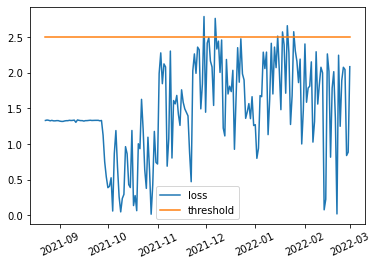

In [35]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()

In [36]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,value
Datetime,,,,
2021-11-30,2.788184,2.5,True,1.950187
2021-12-07,2.762122,2.5,True,3.361295
2022-01-15,2.513572,2.5,True,2.685856
2022-01-18,2.572894,2.5,True,3.344086
2022-01-21,2.659673,2.5,True,3.167698
2022-01-25,2.575251,2.5,True,3.181680


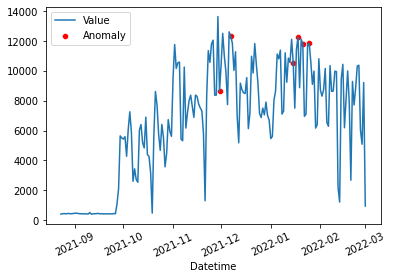

In [37]:
sns.lineplot(x=test[steps:].index, y=scaler.inverse_transform(test[steps:].value), label='Value')
sns.scatterplot(x=anomalies.index, y=scaler.inverse_transform(anomalies.value), color='r', label='Anomaly')
plt.xticks(rotation=25)
plt.legend()

<AxesSubplot:xlabel='Datetime'>

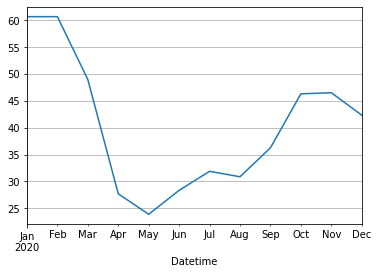

In [131]:
zoomed2021 = data4.loc['2020']

st = zoomed2021['value']
st.plot(grid=True)

In [41]:
zoomed2021.head()

,value
Datetime,
2020-01-31,143.712765
2020-02-29,140.871407
2020-03-31,122.558316
2020-04-30,37.431762
2020-05-31,36.336761


<AxesSubplot:xlabel='Datetime'>

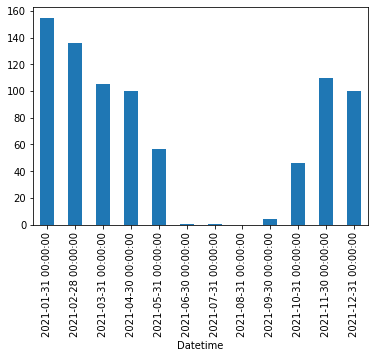

In [101]:
zoomed2021 = data4.loc['2021']

st = zoomed2021['value']
st.plot.bar()